In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pickle
import nibabel as nib

In [2]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score

#
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten, Dense


from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
#from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from scikeras.wrappers import KerasRegressor
from sklearn.ensemble import AdaBoostRegressor

# Load prepared data

In [4]:
dir_path = "/Users/chikakoolsen/opt/python/thesis/code/tdcs_thesis/"
# dir_path = "/Users/mriworkshop/Documents/TDCS/code/tdcs_thesis/"
save_path = dir_path+"data/raw/"
img_path =  dir_path+"data/processed/"
model_path = dir_path+"models/"

## fmap mean all experiments

In [4]:
file_mean = save_path+"fmap_mean_32to38.txt"
columns_mean =['exp', 'mini_exp', 'i', 'j', 'k', 'mean0', 'mean1', 'mean2', 'mean3', 'mean4', 'theory']
data = np.loadtxt(file_mean);

In [5]:
df = pd.DataFrame(data, columns=columns_mean)
df = df.astype({"exp": int, "i": int, "j": int, "k": int, "mini_exp": int})
df

,exp,mini_exp,i,j,k,mean0,mean1,mean2,mean3,mean4,theory
0,36,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,36,1,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0
2,36,1,0,0,2,0.0,0.0,0.0,0.0,0.0,0.0
3,36,1,0,0,3,0.0,0.0,0.0,0.0,0.0,0.0
4,36,1,0,0,4,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
5046267,35,5,43,63,59,0.0,0.0,0.0,0.0,0.0,0.0
5046268,35,5,43,63,60,0.0,0.0,0.0,0.0,0.0,0.0
5046269,35,5,43,63,61,0.0,0.0,0.0,0.0,0.0,0.0
5046270,35,5,43,63,62,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5046272 entries, 0 to 5046271
Data columns (total 11 columns):
 #   Column    Dtype  
---  ------    -----  
 0   exp       int64  
 1   mini_exp  int64  
 2   i         int64  
 3   j         int64  
 4   k         int64  
 5   mean0     float64
 6   mean1     float64
 7   mean2     float64
 8   mean3     float64
 9   mean4     float64
 10  theory    float64
dtypes: float64(6), int64(5)
memory usage: 423.5 MB


# Split data

## Data 1. fmap mean all experiments

In [7]:
df1_train = df[~((df['exp']==36) & ((df['mini_exp']==5) | (df['mini_exp']==6)))]
df1_val =  df[(df['exp']==36) & (df['mini_exp']==5)]
df1_test =  df[(df['exp']==36) & (df['mini_exp']==6)]

In [8]:
print(df1_train.shape)
print(df1_val.shape)
print(df1_test.shape)

(4685824, 11)
(180224, 11)
(180224, 11)


In [9]:
X1_train = df1_train.iloc[:, 5:-1].values 
y1_train = df1_train['theory'].values

X1_test = df1_val.iloc[:, 5:-1].values 
y1_test = df1_val['theory'].values

X1_pred = df1_test.iloc[:, 5:-1].values 
y1_pred = df1_val['theory'].values

In [10]:
print(X1_train.shape)
print(y1_train.shape)
print(X1_test.shape)
print(y1_test.shape)
print(X1_pred.shape)
print(y1_pred.shape)

(4685824, 5)
(4685824,)
(180224, 5)
(180224,)
(180224, 5)
(180224,)


## Data2: One experiment

In [11]:
df_train = df[(df['exp']==36) & (df['mini_exp']!=6)]
df_test = df[(df['exp']==36) & (df['mini_exp']==6)]

## Data4: None zero

In [12]:
df_nonzero = df[(df['mean0']!=0.0) & (df['mean1']!=0.0) & (df['mean2']!=0.0) & (df['mean3']!=0.0) & (df['mean4']!=0.0)]

In [13]:
df_nonzero

,exp,mini_exp,i,j,k,mean0,mean1,mean2,mean3,mean4,theory
30760,36,1,7,32,40,118.874306,102.631088,73.720810,46.604973,35.842915,4.988159
30761,36,1,7,32,41,-69.809402,-88.836975,-115.809509,-147.981812,-157.407669,4.591202
30762,36,1,7,32,42,-501.965088,-518.938477,-546.379456,-559.395264,-578.390381,4.237324
30763,36,1,7,32,43,-729.152405,-748.379883,-771.094543,-794.678772,-810.996643,3.918999
30799,36,1,7,33,15,-1217.971191,-1236.205566,-1261.405762,-1284.039307,-1296.501587,3.371496
...,...,...,...,...,...,...,...,...,...,...,...
5011735,35,5,35,36,23,321.924683,342.532410,335.163940,323.188599,335.096008,8.047899
5011736,35,5,35,36,24,280.548309,296.518066,293.497314,285.676575,294.248779,7.110718
5011737,35,5,35,36,25,216.092102,232.253601,229.062576,219.861847,229.366959,6.379625
5011738,35,5,35,36,26,118.546364,135.199966,132.178497,124.143974,132.757050,5.780618


In [14]:
df4_train = df_nonzero[~((df_nonzero['exp']==36) & ((df_nonzero['mini_exp']==6) | (df_nonzero['mini_exp']==5)))]
df4_test =  df_nonzero[(df_nonzero['exp']==36) & (df_nonzero['mini_exp']==5)]
df4_pred =  df_nonzero[(df_nonzero['exp']==36) & (df_nonzero['mini_exp']==6)]

In [15]:
X4_train = df4_train.iloc[:, 5:-1].values
y4_train = df4_train['theory'].values

X4_test = df4_test.iloc[:, 5:-1].values
y4_test = df4_test['theory'].values

X4_pred = df4_pred.iloc[:, 5:-1].values
y4_pred = df4_pred['theory'].values

In [25]:
# X = df_nonzero.iloc[:, 5:-1].values
# y = df_nonzero['theory'].values

# X4_train, X4_test, y4_train, y4_test = train_test_split(
#     X, y, test_size=0.3, random_state=0)

In [16]:
# print(X.shape)
# print(y.shape)
print(X4_train.shape)
print(y4_train.shape)
print(X4_test.shape)
print(y4_test.shape)
print(X4_pred.shape)
print(y4_pred.shape)

(870485, 5)
(870485,)
(34011, 5)
(34011,)
(34012, 5)
(34012,)


# Include zero 36 to 38

In [23]:
X_train = X4_train
y_train = y4_train
X_test = X4_test
y_test = y4_test

In [12]:
shape = (len(X_train[0]),)
model = keras.Sequential()
model.add(Dense(5, activation='relu', input_shape=shape)) 
model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adamax', loss='mse', metrics=["accuracy"])

2022-11-13 00:28:22.852367: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=[X_test, y_test])

Epoch 1/100
90112/90112 [==============================] - 86s 948us/step - loss: 64.3810 - accuracy: 0.8077 - val_loss: 28.9306 - val_accuracy: 0.8114
Epoch 2/100
90112/90112 [==============================] - 87s 960us/step - loss: 37.0285 - accuracy: 0.8078 - val_loss: 20.2767 - val_accuracy: 0.8114
Epoch 3/100
90112/90112 [==============================] - 82s 912us/step - loss: 35.0177 - accuracy: 0.8078 - val_loss: 17.4437 - val_accuracy: 0.8114
Epoch 4/100
90112/90112 [==============================] - 3168s 35ms/step - loss: 34.0024 - accuracy: 0.8077 - val_loss: 15.2715 - val_accuracy: 0.8114
Epoch 5/100
90112/90112 [==============================] - 78s 861us/step - loss: 33.4753 - accuracy: 0.8077 - val_loss: 14.6795 - val_accuracy: 0.8112
Epoch 6/100
90112/90112 [==============================] - 75s 833us/step - loss: 33.2833 - accuracy: 0.8077 - val_loss: 13.7383 - val_accuracy: 0.8112
Epoch 7/100
90112/90112 [==============================] - 83s 919us/step - loss: 33.06

In [14]:
train_pred = model.predict(X_train)
print(mse(train_pred, y_train))
print(mape(train_pred, y_train))
test_pred = model.predict(X_test)
print(mse(test_pred, y_test))
print(mape(test_pred, y_test))

90112/90112 [==============================] - 58s 646us/step
32.13113009171346
0.8639515224917037
5632/5632 [==============================] - 4s 654us/step
11.503959924863885
0.8785913891610487


In [15]:
model.evaluate(X_test, y_test)

5632/5632 [==============================] - 4s 756us/step - loss: 11.5037 - accuracy: 0.8112


[11.503734588623047, 0.8112238049507141]

In [16]:
np.corrcoef(test_pred.flatten(), y_test)

array([[1.        , 0.89091311],
       [0.89091311, 1.        ]])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                60        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 291
Trainable params: 291
Non-trainable params: 0
_________________________________________________________________


In [18]:
history.history

{'loss': [64.38101959228516,
  37.02849197387695,
  35.01773452758789,
  34.002403259277344,
  33.47531509399414,
  33.28331756591797,
  33.063594818115234,
  32.87491989135742,
  32.64092254638672,
  32.527706146240234,
  32.4524040222168,
  32.43301010131836,
  32.35726547241211,
  32.315399169921875,
  32.24143981933594,
  32.21194076538086,
  32.19076156616211,
  32.218902587890625,
  32.15449142456055,
  32.237972259521484,
  32.186405181884766,
  32.187496185302734,
  32.04540252685547,
  32.06322479248047,
  32.09186553955078,
  31.944923400878906,
  31.975614547729492,
  31.961957931518555,
  31.96839141845703,
  31.91943359375,
  31.945650100708008,
  31.8912296295166,
  31.892553329467773,
  31.897510528564453,
  31.873777389526367,
  31.841564178466797,
  31.863245010375977,
  31.966325759887695,
  31.905590057373047,
  31.907508850097656,
  31.823766708374023,
  31.884929656982422,
  31.86187171936035,
  31.89930534362793,
  31.916975021362305,
  31.86927604675293,
  31.921

In [19]:
file = img_path+'model_36to38.sav'
pickle.dump(model, open(file, 'wb'))

INFO:tensorflow:Assets written to: ram:///var/folders/yd/vkjb_lqj2_30lnyhzhjqtg9w0000gp/T/tmplsx3uus6/assets


In [21]:
load_model = pickle.load(open(file, 'rb'))
result = load_model.evaluate(X_test, y_test)
print(result)

1063/1063 [==============================] - 1s 842us/step - loss: 56.8737 - accuracy: 8.8204e-04
[56.87367630004883, 0.0008820416405797005]


## Plot

### Loss function (MSE)

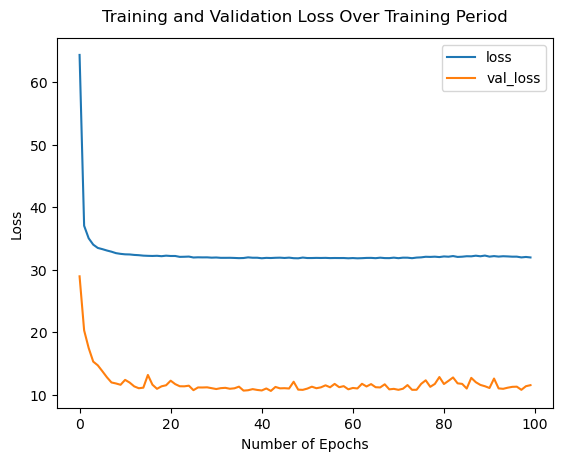

In [20]:
model_df = pd.DataFrame(history.history)
model_df[['loss', 'val_loss']].plot()
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Training Period", pad=12);

### Accuracy

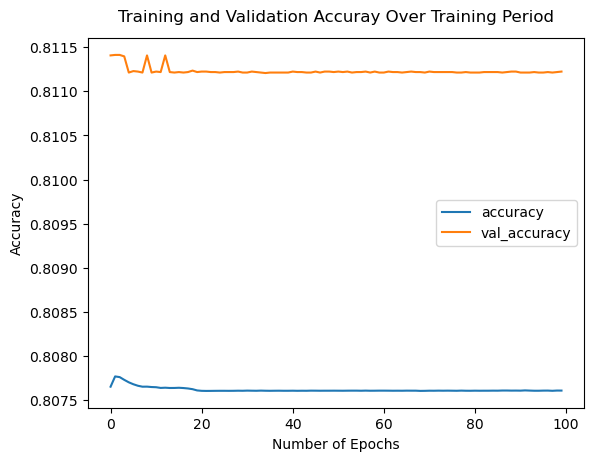

In [21]:
model_df[['accuracy', 'val_accuracy']].plot()
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuray Over Training Period", pad=12);

### Theory vs Predict

r: 0.89091%, st_er: 0.000897%
y = 0.7469*x + 0.2675


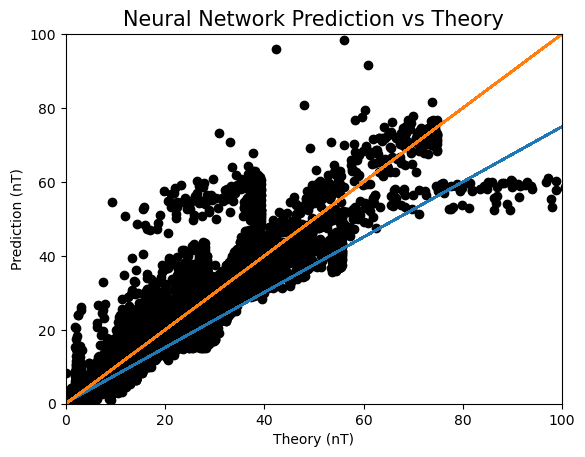

In [22]:
x = y_test.flatten()
y = test_pred.flatten()
m, b, r, p, st_er = stats.linregress(x,y) 

yfit = [b + m * xi for xi in x]
yisx = [0 + 1 * xi for xi in x]
plt.plot(x, yfit)
plt.plot(x, yisx)

plt.scatter(y_test, test_pred,  color='black')
plt.axis([0,100, 0, 100])
plt.xlabel("Theory (nT)")
plt.ylabel("Prediction (nT)")
plt.title("Neural Network Prediction vs Theory", fontsize=15)
# print(r, st_er)
print("r: {:.5f}, st_er: {:.6f}".format(r, st_er))
print("y = "+str(round(m,4))+"*x + "+str(round(b,4)))

# Output data

In [24]:
test_pred = model.predict(X1_pred)

5632/5632 [==============================] - 4s 737us/step


In [25]:
df_test

,exp,mini_exp,i,j,k,mean0,mean1,mean2,mean3,mean4,theory
901120,36,6,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
901121,36,6,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0
901122,36,6,0,0,2,0.0,0.0,0.0,0.0,0.0,0.0
901123,36,6,0,0,3,0.0,0.0,0.0,0.0,0.0,0.0
901124,36,6,0,0,4,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1081339,36,6,43,63,59,0.0,0.0,0.0,0.0,0.0,0.0
1081340,36,6,43,63,60,0.0,0.0,0.0,0.0,0.0,0.0
1081341,36,6,43,63,61,0.0,0.0,0.0,0.0,0.0,0.0
1081342,36,6,43,63,62,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
df_test['predict'] = test_pred

/var/folders/yd/vkjb_lqj2_30lnyhzhjqtg9w0000gp/T/ipykernel_30829/4195812830.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predict'] = test_pred


In [27]:
np.savetxt(img_path+"nn_36to38.txt", df_test[['i', 'j', 'k', 'predict']], fmt="%i %i %i %s")

In [85]:
df_test

,exp,mini_exp,i,j,k,mean0,mean1,mean2,mean3,mean4,theory,predict
901120,36,6,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.011854
901121,36,6,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.011854
901122,36,6,0,0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.011854
901123,36,6,0,0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.011854
901124,36,6,0,0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.011854
...,...,...,...,...,...,...,...,...,...,...,...,...
1081339,36,6,43,63,59,0.0,0.0,0.0,0.0,0.0,0.0,0.011854
1081340,36,6,43,63,60,0.0,0.0,0.0,0.0,0.0,0.0,0.011854
1081341,36,6,43,63,61,0.0,0.0,0.0,0.0,0.0,0.0,0.011854
1081342,36,6,43,63,62,0.0,0.0,0.0,0.0,0.0,0.0,0.011854


In [30]:
# non zero
df4_test['predict'] = test_pred

/var/folders/2c/z02d0fq542v7qg_9kr87__k40000gp/T/ipykernel_79296/4220111569.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4_test['predict'] = test_pred


In [92]:
df_test['predict'] = 0.00

/var/folders/2c/z02d0fq542v7qg_9kr87__k40000gp/T/ipykernel_79296/3257651465.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predict'] = 0.00


In [93]:
df_out = df_test[['i', 'j', 'k', 'predict']]
df_pre = df4_test[['i', 'j', 'k', 'predict']]

In [99]:
df_out.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180224 entries, 901120 to 1081343
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   i        180224 non-null  int64  
 1   j        180224 non-null  int64  
 2   k        180224 non-null  int64  
 3   predict  180224 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 6.9 MB


In [122]:
for x in range(len(df_pre)):
    i = df_pre.iloc[x, :]['i'].astype(int)
    j = df_pre.iloc[x, :]['j'].astype(int)
    k = df_pre.iloc[x, :]['k'].astype(int)
    pred = df_pre.iloc[x, :]['predict']
    idx = df_out[(df_out['i']==i) & (df_out['j']==j) & (df_out['k']==k)].index
    df_out.loc[idx, 'predict']= pred

In [127]:
df_pre

,i,j,k,predict
931880,7,32,40,5.183412
931881,7,32,41,4.673711
931882,7,32,42,4.348357
931883,7,32,43,5.062788
931919,7,33,15,3.794160
...,...,...,...,...
1050968,36,37,24,5.607471
1050979,36,37,35,13.007126
1050982,36,37,38,8.704618
1050983,36,37,39,6.513861


In [124]:
df_out[(df_out['i']==7) & (df_out['j']==32) & (df_out['k']==40)]

,i,j,k,predict
931880,7,32,40,5.183412


In [125]:
df_out

,i,j,k,predict
901120,0,0,0,0.0
901121,0,0,1,0.0
901122,0,0,2,0.0
901123,0,0,3,0.0
901124,0,0,4,0.0
...,...,...,...,...
1081339,43,63,59,0.0
1081340,43,63,60,0.0
1081341,43,63,61,0.0
1081342,43,63,62,0.0


In [126]:
np.savetxt(img_path+"nn_nonzero_36to38.txt", df_out[['i', 'j', 'k', 'predict']], fmt="%i %i %i %s")

# Nonzero 32 to 38

In [17]:
X_train = X4_train
y_train = y4_train
X_test = X4_test
y_test = y4_test

In [20]:
shape = (len(X_train[0]),)
model = keras.Sequential()
model.add(Dense(10, activation='relu', input_shape=shape)) 
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adamax', loss='mse', metrics=["accuracy"])

In [21]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=[X_test, y_test])

Epoch 1/100
27203/27203 [==============================] - 30s 1ms/step - loss: 17205.4766 - accuracy: 1.1488e-04 - val_loss: 213.2913 - val_accuracy: 2.9402e-05
Epoch 2/100
27203/27203 [==============================] - 27s 1ms/step - loss: 17096.2969 - accuracy: 2.8720e-05 - val_loss: 152.1224 - val_accuracy: 2.9402e-05
Epoch 3/100
27203/27203 [==============================] - 26s 958us/step - loss: 17070.7910 - accuracy: 2.8720e-05 - val_loss: 128.0684 - val_accuracy: 2.9402e-05
Epoch 4/100
27203/27203 [==============================] - 26s 971us/step - loss: 17061.9336 - accuracy: 2.8720e-05 - val_loss: 124.1674 - val_accuracy: 2.9402e-05
Epoch 5/100
27203/27203 [==============================] - 26s 971us/step - loss: 17055.9355 - accuracy: 2.9868e-05 - val_loss: 118.7897 - val_accuracy: 2.9402e-05
Epoch 6/100
27203/27203 [==============================] - 26s 959us/step - loss: 17051.3320 - accuracy: 2.9868e-05 - val_loss: 105.8017 - val_accuracy: 2.9402e-05
Epoch 7/100
27203/27

In [22]:
train_pred = model.predict(X_train)
print(mse(train_pred, y_train))
print(mape(train_pred, y_train))
test_pred = model.predict(X_test)
print(mse(test_pred, y_test))
print(mape(test_pred, y_test))

27203/27203 [==============================] - 20s 717us/step
17026.977647823092
0.257609840581334
1063/1063 [==============================] - 1s 710us/step
56.64768963544796
0.2100135234417976


In [24]:
model.evaluate(X_test, y_test)

1063/1063 [==============================] - 1s 888us/step - loss: 56.6477 - accuracy: 2.9402e-05


[56.6476936340332, 2.9402252039290033e-05]

In [25]:
np.corrcoef(test_pred.flatten(), y_test)

array([[1.        , 0.83818038],
       [0.83818038, 1.        ]])

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 10)                60        
                                                                 
 dense_5 (Dense)             (None, 10)                110       
                                                                 
 dense_6 (Dense)             (None, 10)                110       
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                                 
Total params: 291
Trainable params: 291
Non-trainable params: 0
_________________________________________________________________


In [27]:
history.history

{'loss': [17205.4765625,
  17096.296875,
  17070.791015625,
  17061.93359375,
  17055.935546875,
  17051.33203125,
  17049.267578125,
  17047.994140625,
  17044.0546875,
  17041.265625,
  17039.765625,
  17038.33984375,
  17036.169921875,
  17036.029296875,
  17034.310546875,
  17034.75,
  17033.642578125,
  17032.890625,
  17031.634765625,
  17031.685546875,
  17034.796875,
  17032.91015625,
  17031.80078125,
  17031.75,
  17027.759765625,
  17031.6953125,
  17032.2421875,
  17030.244140625,
  17030.904296875,
  17032.478515625,
  17030.0703125,
  17030.443359375,
  17028.552734375,
  17028.408203125,
  17030.275390625,
  17033.08203125,
  17029.4921875,
  17030.58203125,
  17028.828125,
  17030.306640625,
  17031.537109375,
  17029.388671875,
  17028.19921875,
  17029.51171875,
  17027.099609375,
  17031.845703125,
  17027.685546875,
  17029.474609375,
  17029.189453125,
  17028.66015625,
  17028.0859375,
  17028.837890625,
  17028.73046875,
  17027.533203125,
  17027.990234375,
  17

In [28]:
file = model_path+'model_nonzero_32to38.sav'
pickle.dump(model, open(file, 'wb'))

INFO:tensorflow:Assets written to: ram:///var/folders/yd/vkjb_lqj2_30lnyhzhjqtg9w0000gp/T/tmp9vpalns4/assets


In [25]:
file = model_path+'model_nonzero_32to38.sav'
load_model = pickle.load(open(file, 'rb'))
result = load_model.evaluate(X_test, y_test)
print(result)

ImportError: No module named scikeras._saving_utils

## Plot

### Loss function (MSE)

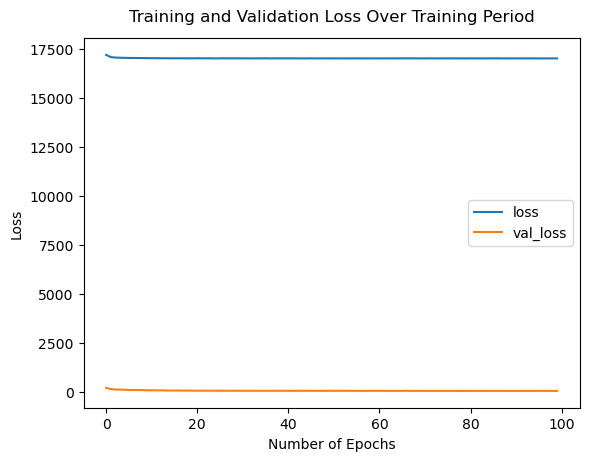

In [29]:
model_df = pd.DataFrame(history.history)
model_df[['loss', 'val_loss']].plot()
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Training Period", pad=12);

### Accuracy

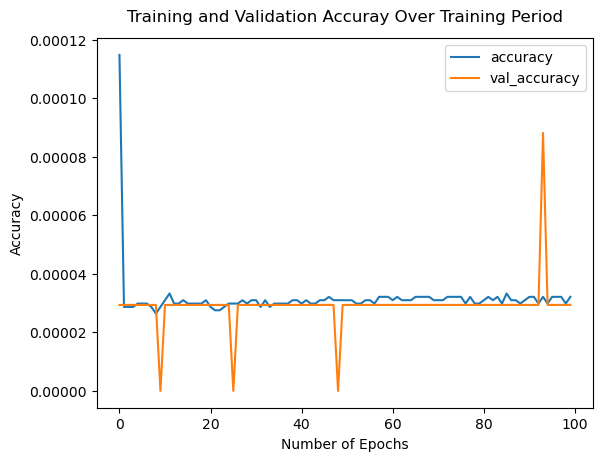

In [30]:
model_df[['accuracy', 'val_accuracy']].plot()
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuray Over Training Period", pad=12);

### Theory vs Predict

r: 0.83818, st_er: 0.002442
y = 0.6921*x + 3.9481


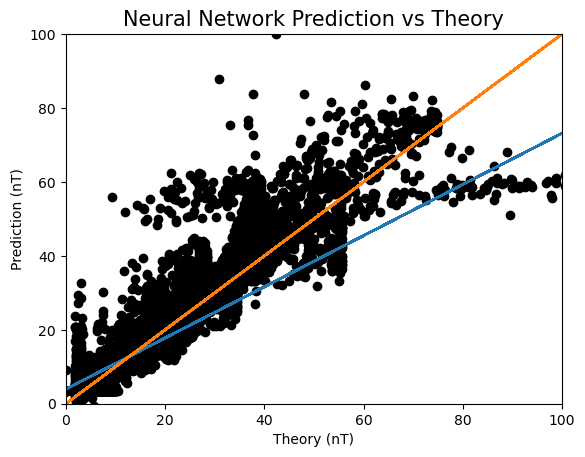

In [31]:
x = y_test.flatten()
y = test_pred.flatten()
m, b, r, p, st_er = stats.linregress(x,y) 

yfit = [b + m * xi for xi in x]
yisx = [0 + 1 * xi for xi in x]
plt.plot(x, yfit)
plt.plot(x, yisx)

plt.scatter(y_test, test_pred,  color='black')
plt.axis([0,100, 0, 100])
plt.xlabel("Theory (nT)")
plt.ylabel("Prediction (nT)")
plt.title("Neural Network Prediction vs Theory", fontsize=15)
# print(r, st_er)
print("r: {:.5f}, st_er: {:.6f}".format(r, st_er))
print("y = "+str(round(m,4))+"*x + "+str(round(b,4)))

### Erode

### Physics vs Theory

r: 0.06228, st_er: 0.023157
y = 0.6134*x + -0.4516


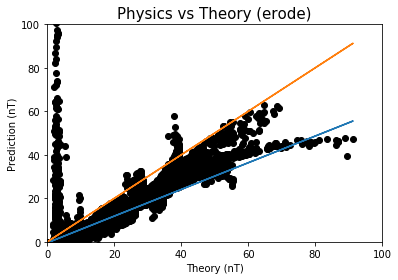

In [15]:
xminusy = "56minus54" # run 6
erode = '1'
sub_path = dir_path+"data/external/R21_36_Cyl_Aqueous/"
cwd = sub_path+"NIFTI/bmaps_numpy/"+xminusy+"/"
img_meas = nib.load(cwd+"/diff_fmap_Mean_erode"+erode+".nii.gz")
img_theo = nib.load(cwd+"/Bvals_erode"+erode+".nii.gz")

data_meas = img_meas.get_data()
data_theo = img_theo.get_data()
x = data_theo.flatten()
y = data_meas.flatten()

m, b, r, p, st_er = stats.linregress(x,y) 

yfit = [b + m * xi for xi in x]
yisx = [0 + 1 * xi for xi in x]
plt.plot(x, yfit)
plt.plot(x, yisx)

plt.scatter(x, y,  color='black')
plt.axis([0,100, 0, 100])
plt.xlabel("Theory (nT)")
plt.ylabel("Prediction (nT)")
plt.title("Physics vs Theory (erode)", fontsize=15)
# print(r, st_er)
print("r: {:.5f}, st_er: {:.6f}".format(r, st_er))
print("y = "+str(round(m,4))+"*x + "+str(round(b,4)))

In [12]:
cwd

'/Users/chikakoolsen/opt/python/thesis/code/tdcs_thesis/data/processed/NIFTI/bmaps_numpy/46minus44/'

### Predict vs Theory

r: 0.98466, st_er: 0.000440
y = 1.0534*x + 0.0352


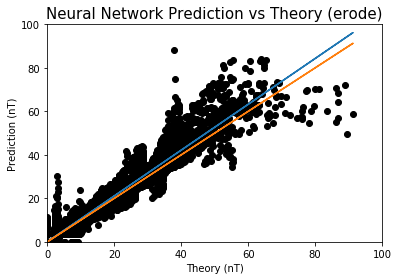

In [16]:
img_pred = nib.load(img_path+"/predicted_nn_nonzero_32to38_erode.nii.gz")
data_pred = img_pred.get_data()

x = data_theo.flatten()
y = data_pred.flatten()
m, b, r, p, st_er = stats.linregress(x,y) 

yfit = [b + m * xi for xi in x]
yisx = [0 + 1 * xi for xi in x]
plt.plot(x, yfit)
plt.plot(x, yisx)

plt.scatter(x, y,  color='black')
plt.axis([0,100, 0, 100])
plt.xlabel("Theory (nT)")
plt.ylabel("Prediction (nT)")
plt.title("Neural Network Prediction vs Theory (erode)", fontsize=15)
# print(r, st_er)
print("r: {:.5f}, st_er: {:.6f}".format(r, st_er))
print("y = "+str(round(m,4))+"*x + "+str(round(b,4)))

# Output data

In [92]:
test_pred = model.predict(X4_pred)

1063/1063 [==============================] - 1s 727us/step


In [93]:
df4_pred['predict'] = test_pred

/var/folders/yd/vkjb_lqj2_30lnyhzhjqtg9w0000gp/T/ipykernel_59995/2364276288.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4_pred['predict'] = test_pred


In [94]:
df4_pred

,exp,mini_exp,i,j,k,mean0,mean1,mean2,mean3,mean4,theory,predict
931880,36,6,7,32,40,-183.593781,-184.268631,-199.538742,-215.528793,-215.355865,4.988159,1.592257
931881,36,6,7,32,41,-383.761566,-383.066467,-395.916077,-417.522858,-420.110077,4.591202,1.592257
931882,36,6,7,32,42,-779.052185,-785.270813,-803.943787,-811.441101,-799.951233,4.237324,1.592257
931883,36,6,7,32,43,-1017.557312,-1026.294189,-1037.133667,-1050.012451,-1046.674072,3.918999,1.592257
931919,36,6,7,33,15,-1508.948120,-1513.032471,-1527.041992,-1536.478027,-1540.133301,3.371496,1.592257
...,...,...,...,...,...,...,...,...,...,...,...,...
1050968,36,6,36,37,24,-27.330389,-28.598026,-46.617607,-59.281792,-58.657875,7.175758,1.592257
1050979,36,6,36,37,35,171.250366,175.768433,151.715485,130.792816,139.797287,8.527348,1.592257
1050982,36,6,36,37,38,-96.352455,-94.962585,-115.256683,-131.555984,-127.650993,6.039019,1.592257
1050983,36,6,36,37,39,-235.110947,-235.878754,-253.580444,-268.104340,-266.388824,5.501382,1.592257


In [95]:
df_test

,exp,mini_exp,i,j,k,mean0,mean1,mean2,mean3,mean4,theory,predict
901120,36,6,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
901121,36,6,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
901122,36,6,0,0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
901123,36,6,0,0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0
901124,36,6,0,0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1081339,36,6,43,63,59,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1081340,36,6,43,63,60,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1081341,36,6,43,63,61,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1081342,36,6,43,63,62,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [96]:
df_test['predict'] = 0.00

/var/folders/yd/vkjb_lqj2_30lnyhzhjqtg9w0000gp/T/ipykernel_59995/3257651465.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predict'] = 0.00


In [97]:
df_out = df_test[['i', 'j', 'k', 'predict']]
df_pre = df4_pred[['i', 'j', 'k', 'predict']]

In [98]:
df_out.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180224 entries, 901120 to 1081343
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   i        180224 non-null  int64  
 1   j        180224 non-null  int64  
 2   k        180224 non-null  int64  
 3   predict  180224 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 10.9 MB


In [ ]:
for x in range(len(df_pre)):
    i = df_pre.iloc[x, :]['i'].astype(int)
    j = df_pre.iloc[x, :]['j'].astype(int)
    k = df_pre.iloc[x, :]['k'].astype(int)
    pred = df_pre.iloc[x, :]['predict']
    idx = df_out[(df_out['i']==i) & (df_out['j']==j) & (df_out['k']==k)].index
    df_out.loc[idx, 'predict']= pred

In [ ]:
df_pre

In [ ]:
df_out[(df_out['i']==7) & (df_out['j']==32) & (df_out['k']==40)]

In [ ]:
df_out

In [ ]:
np.savetxt(img_path+"nn_nonzero_32to38.txt", df_out[['i', 'j', 'k', 'predict']], fmt="%i %i %i %s")

# Play Ground

# Compare each dataset

## Data1: fmap means all experiments

In [176]:
X_train = X1_train
y_train = y1_train
X_test = X1_test
y_test = y1_test

In [177]:
model = keras.Sequential()
model.add(Dense(10, activation='relu', input_shape=[len(X_train[0])]))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))
#
model.compile(optimizer= 'adam', loss='mse', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=20, verbose=0, validation_data=[X_test, y_test])

In [178]:
train_pred = model.predict(X_train)
print(mse(train_pred, y_train))
test_pred = model.predict(X_test)
print(mse(test_pred, y_test))

70964/70964 [==============================] - 54s 761us/step
30.170082550978588
30413/30413 [==============================] - 25s 830us/step
37.97403427399727


In [179]:
r2_score(y_test, test_pred)

0.5055974148648721

In [180]:
model.evaluate(X_test, y_test)

30413/30413 [==============================] - 25s 811us/step - loss: 37.9739 - accuracy: 0.8084


[37.97385787963867, 0.8083938956260681]

In [181]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 10)                60        
                                                                 
 dense_37 (Dense)            (None, 10)                110       
                                                                 
 dense_38 (Dense)            (None, 10)                110       
                                                                 
 dense_39 (Dense)            (None, 1)                 11        
                                                                 
Total params: 291
Trainable params: 291
Non-trainable params: 0
_________________________________________________________________


## Data2: One experiment

In [182]:
X_train = X2_train
y_train = y2_train
X_test = X2_test
y_test = y2_test

In [183]:
model2 = keras.Sequential()
model2.add(Dense(10, activation='relu', input_shape=[len(X_train[0])]))
model2.add(Dense(10, activation='relu'))
model2.add(Dense(10, activation='relu'))
model2.add(Dense(1))

#
model2.compile(optimizer= 'adam', loss='mse', metrics=['accuracy'])
history2 = model2.fit(X_train, y_train, epochs=20, verbose=0, validation_data=[X_test, y_test])


In [184]:
train_pred2 = model2.predict(X_train)
print(mse(train_pred2, y_train))
test_pred2 = model2.predict(X_test)
print(mse(test_pred2, y_test))

28160/28160 [==============================] - 21s 737us/step
10.787611349421352
5632/5632 [==============================] - 4s 720us/step
11.598423677038422


In [185]:
r2_score(y_test, test_pred2)

0.7879580102236565

In [186]:
model2.evaluate(X_test, y_test)

5632/5632 [==============================] - 5s 872us/step - loss: 11.5982 - accuracy: 0.8112


[11.598172187805176, 0.8112071752548218]

In [187]:
model2.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 10)                60        
                                                                 
 dense_41 (Dense)            (None, 10)                110       
                                                                 
 dense_42 (Dense)            (None, 10)                110       
                                                                 
 dense_43 (Dense)            (None, 1)                 11        
                                                                 
Total params: 291
Trainable params: 291
Non-trainable params: 0
_________________________________________________________________


## Data3: 55 fmap means

In [188]:
X_train = X3_train
y_train = y3_train
X_test = X3_test
y_test = y3_test

In [189]:
model3 = keras.Sequential()
model3.add(Dense(10, activation='relu', input_shape=[len(X_train[0])]))
model3.add(Dense(10, activation='relu'))
model3.add(Dense(10, activation='relu'))
model3.add(Dense(1))
#
model3.compile(optimizer= 'adam', loss='mse', metrics=['accuracy'])
history3 = model3.fit(X_train, y_train, epochs=20, verbose=0, validation_data=[X_test, y_test])


In [190]:
train_pred3 = model3.predict(X_train)
print(mse(train_pred3, y_train))
test_pred3 = model3.predict(X_test)
print(mse(test_pred3, y_test))

70964/70964 [==============================] - 49s 691us/step
25.653226663055843
30413/30413 [==============================] - 21s 679us/step
33.91757302155358


In [191]:
r2_score(y_test, test_pred3)

0.5584104743159171

In [192]:
model3.evaluate(X_test, y_test)

30413/30413 [==============================] - 25s 809us/step - loss: 33.9176 - accuracy: 0.8084


[33.9175910949707, 0.8083938956260681]

In [193]:
model3.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 10)                560       
                                                                 
 dense_45 (Dense)            (None, 10)                110       
                                                                 
 dense_46 (Dense)            (None, 10)                110       
                                                                 
 dense_47 (Dense)            (None, 1)                 11        
                                                                 
Total params: 791
Trainable params: 791
Non-trainable params: 0
_________________________________________________________________


## Data4: None zero

In [39]:
X_train = X4_train
y_train = y4_train
X_test = X4_test
y_test = y4_test

In [28]:
model4 = keras.Sequential()
model4.add(Dense(20, activation='relu', input_shape=[len(X_train[0])]))
model4.add(Dense(1))
#
model4.compile(optimizer= 'adam', loss='mse', metrics=['accuracy'])
history4 = model4.fit(X_train, y_train, epochs=20, validation_data=[X_test, y_test])


2022-10-26 12:02:18.273343: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20
13623/13623 [==============================] - 17s 1ms/step - loss: 775.6888 - accuracy: 5.0696e-04 - val_loss: 280.3866 - val_accuracy: 9.8486e-04
Epoch 2/20
13623/13623 [==============================] - 16s 1ms/step - loss: 254.4488 - accuracy: 5.9642e-04 - val_loss: 239.9096 - val_accuracy: 4.8173e-05
Epoch 3/20
13623/13623 [==============================] - 16s 1ms/step - loss: 244.3139 - accuracy: 6.0331e-04 - val_loss: 426.1392 - val_accuracy: 0.0011
Epoch 4/20
13623/13623 [==============================] - 16s 1ms/step - loss: 234.7317 - accuracy: 6.1707e-04 - val_loss: 236.3913 - val_accuracy: 8.9922e-04
Epoch 5/20
13623/13623 [==============================] - 17s 1ms/step - loss: 226.6837 - accuracy: 6.7212e-04 - val_loss: 226.9637 - val_accuracy: 9.2063e-04
Epoch 6/20
13623/13623 [==============================] - 16s 1ms/step - loss: 217.3771 - accuracy: 6.9047e-04 - val_loss: 230.2182 - val_accuracy: 1.0705e-04
Epoch 7/20
13623/13623 [==========================

In [29]:
train_pred4 = model4.predict(X_train)
print(mse(train_pred4, y_train))
test_pred4 = model4.predict(X_test)
print(mse(test_pred4, y_test))

13623/13623 [==============================] - 10s 700us/step
184.91616526100555
5839/5839 [==============================] - 4s 672us/step
199.72171091691504


In [30]:
model4.evaluate(X_test, y_test)

5839/5839 [==============================] - 5s 777us/step - loss: 199.7217 - accuracy: 9.0458e-04


[199.72171020507812, 0.0009045753395184875]

In [31]:
model4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                120       
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________


In [32]:
history4.history

{'loss': [775.6888427734375,
  254.44879150390625,
  244.31385803222656,
  234.73170471191406,
  226.68370056152344,
  217.37705993652344,
  211.0164031982422,
  206.1196746826172,
  198.62127685546875,
  194.85061645507812,
  192.2696990966797,
  189.657470703125,
  189.12733459472656,
  187.17984008789062,
  187.6508331298828,
  186.62896728515625,
  186.11622619628906,
  185.31565856933594,
  184.93045043945312,
  184.64312744140625],
 'accuracy': [0.0005069597973488271,
  0.00059642328415066,
  0.0006033051176927984,
  0.0006170687265694141,
  0.0006721231620758772,
  0.0006904746405780315,
  0.0007202958222478628,
  0.0007019443437457085,
  0.0006812989013269544,
  0.0006124808569438756,
  0.0005207234062254429,
  0.0004725507751572877,
  0.0004174963105469942,
  0.0004129084409214556,
  0.00044731746311299503,
  0.0004886083188466728,
  0.00043584778904914856,
  0.0004771386447828263,
  0.00044731746311299503,
  0.00044731746311299503],
 'val_loss': [280.3866271972656,
  239.9096

## Plot

### Loss function (MSE)

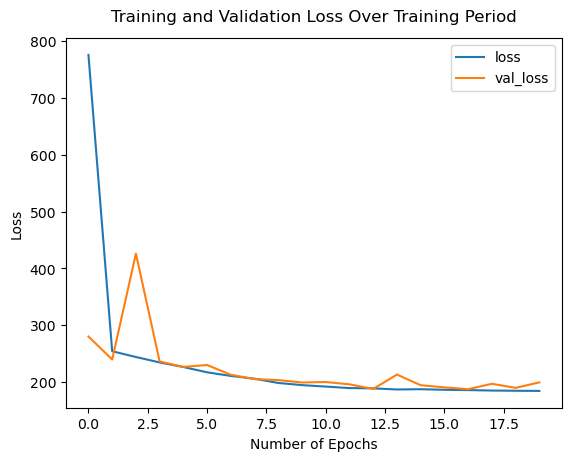

In [33]:
model_df = pd.DataFrame(history4.history)
model_df[['loss', 'val_loss']].plot()
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Training Period", pad=12);

### Accuracy

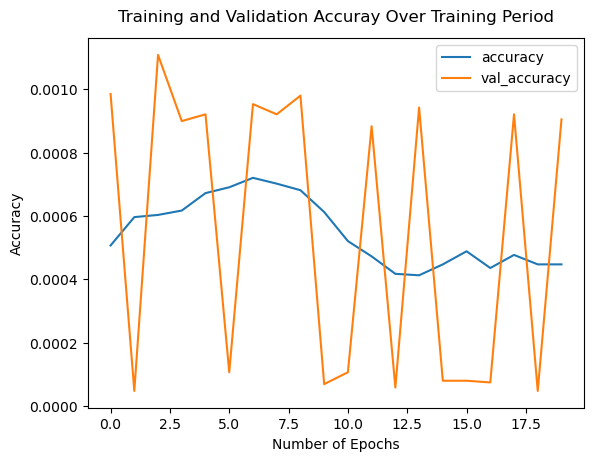

In [34]:
model_df[['accuracy', 'val_accuracy']].plot()
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuray Over Training Period", pad=12);

### Theory vs Predict

r: 0.55524%, st_er: 0.001131%
y = 0.3264*x + 7.3193


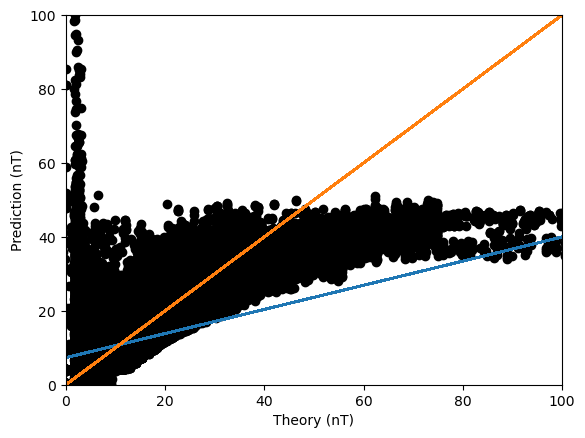

In [42]:
x = y_test.flatten()
y = test_pred4.flatten()
m, b, r, p, st_er = stats.linregress(x,y) 

yfit = [b + m * xi for xi in x]
yisx = [0 + 1 * xi for xi in x]
plt.plot(x, yfit)
plt.plot(x, yisx)

plt.scatter(y_test, test_pred4,  color='black')
plt.axis([0,100, 0, 100])
plt.xlabel("Theory (nT)")
plt.ylabel("Prediction (nT)")
# print(r, st_er)
print("r: {:.5f}%, st_er: {:.6f}%".format(r, st_er))
print("y = "+str(round(m,4))+"*x + "+str(round(b,4)))

# Output image data

In [115]:
df['predict'] = test_pred
df_test['predict'] = test_pred2
df_55['predict'] = test_pred3
df_on['predict'] = test_pred4

/var/folders/yd/vkjb_lqj2_30lnyhzhjqtg9w0000gp/T/ipykernel_3032/2079570890.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predict'] = test_pred
/var/folders/yd/vkjb_lqj2_30lnyhzhjqtg9w0000gp/T/ipykernel_3032/2079570890.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predict2'] = test_pred2


In [116]:
np.savetxt(save_path+"nn.txt", df[['i', 'j', 'k', 'predict']], fmt="%i %i %i %s")

In [117]:
np.savetxt(save_path+"nn2.txt", df_test[['i', 'j', 'k', 'predict']], fmt="%i %i %i %s")

In [ ]:
np.savetxt(save_path+"nn3.txt", df_55[['i', 'j', 'k', 'predict']], fmt="%i %i %i %s")

In [ ]:
np.savetxt(save_path+"nn4.txt", df_on[['i', 'j', 'k', 'predict']], fmt="%i %i %i %s")